### Overview
This is 1/3 scripts, focussed only on exploring the data, and its important variables utilizing a basic Random forest model.

National Institutes of Health, and Center for Disease Control and Prevention and the U.S. Census Bureau conducted a National Longitudinal Mortality Study (NLMS) for the purpose of studying effects of differentials in demographic and socio-economic characteristics on mortality.
Mortality information was obtained from death certificates available for deceased persons through the National Center for Health Statistics. Standard demographic and socio-economic variables such as education, income, and employment, as well as information collected from death certificates including cause of death are available for analyses.

The dataset is 4302 rows x 31 columns, with attributes in respect to citizenship, demographics, family, education, profession, income, health, habits, mortality.
We'll be looking at how different attributes of an individual might drive them towards harming oneself for Life, and if there's anything that can be done to prevent such cases, by employing machine learning techniques to predict in advance.

In [1]:
# import required libraries
# ml_toolkit is a custom script made to include the generic functionalities required in one and every data exploration task. 
# The individual script enhances its re-usability.
from ml_toolkit import encode_str_columns, fetch_train_test_split, write_excel_sheet_v2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from eli5.sklearn import PermutationImportance
import eli5

from IPython.display import Markdown as md
import random

c:\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
"""
    an inline function to fetch a basic Random forest quickly for exploration
"""
def get_rf_model( X_train, y_train, output_column, random_state = 42 ):
    rf_model = RandomForestClassifier( n_estimators = 100, random_state = random_state ).fit( X_train, y_train )
    return rf_model

### Read raw data

In [3]:
data = pd.read_csv( "data_/11.csv", dtype = str )

In [4]:
# transform variable names to follow same letter casing
data.columns = [ x.title() for x in data.columns ]

# type cast the two number variables, age and follow up period to Int
number_cols = [ "Age", "Follow" ]
data[ number_cols ] = data[ number_cols ].astype( int )

# create a new variable for Suicides using the causes of death, segregate health related deaths by Suicide = 0, Suicides by 1, and Accidents by 2
data[ "Suicide" ] = 0
data.loc[ data[ "Cause113" ].isin( [ '105', '106' ] ), "Suicide" ] = 1
data.loc[ data[ "Cause113" ].isin( [ '100', '104', '107', '108', '109' ] ), "Suicide" ] = 2

# create a new variable to note if the individual was working
data[ "Working" ] = 1
data.loc[ data[ "Occ" ].isnull(), "Working" ] = 0

In [5]:
"""
impute missing values for occupational, and industry codes. 
they are blank for individuals who dont work or the ones for whom the detail could not be fetched
"""
data[ "Majocc" ].fillna( -1, inplace = True )
data[ "Majind" ].fillna( -1, inplace = True )

In [6]:
# read data
# data = pd.read_csv( "data_/data.csv", dtype = str )
output_column = "Suicide"

check for any attributes which are more inclined towards any particular output
for this, we are checking if any of the attributes are observed with Suicides and Accidents for more than 70% of the data

In [7]:
total_rows = data.shape[ 0 ]
col_prop = {}
for x in data.columns:
    col_prop[ x ] = [ 
        ( ( data[ x ].notnull() ) & ( data[ output_column ] == '1' ) ).sum() / total_rows, 
        ( ( data[ x ].notnull() ) & ( data[ output_column ] == '0' ) ).sum() /  total_rows
    ]

cols_to_explore = [
    ( x, y ) for x, y in col_prop.items()
    if ( y[0] + y[1] > 0.7 )
]

c:\python\python37\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [8]:
cols_to_explore

[]

Now, as we see the proportion of the attributes is similar in both cases of Suicides or Accidents, and they actually have more than 40% of blanks in the data. 
They do not seem to really belong specifically to any such case, but will need to be validated for their values in the analysis now.

### data overview
The numeric attributes are:
1. Age - age of the person at the time of the survey
2. Follow- The length of follow-up period in days

The categorical features include:
1. Sex- Gender
2. POB - Region of Birth
3. Race - An expanded version of race which separates the American Indian, etc. and Asian, etc. out of the Other category in early CPS files
4. Hisp - Hispanic origin classifies all persons by Mexican, Hispanic (not Mexican) or Non-Hispanic (Not Mexican or Hispanic) origin
5. Ms- marital status
6. RELTRF - Relationship to reference person within the household
7. HHNUM - number of persons residing in the household at the time of the interview
8. SSNYN - Indicator of the presence or absence of Social Security Number on the CPS record
9. STATER - state of residence at the date of interview
10. URBAN - Urban or rural status
11. SMSAST - Is a household located in an SMSA or not? (SMSA - standard metropolitan statistical area)
12. TENURE - the type of ownership of the residence
13. EDUC- highest grade completed
14. VT - Indicates whether person was U.S. veteran
15. CITIZEN - person’s citizenship at the time of survey
16. health - the status of person health at the time of survey
17. Working - if the person was employed
18. ESR - Recoded employment status
19. IND - Job specific industrial classification codes
20. MAJIND - Major industry classification recode of 2007 specific industry
21. RCOW - Recoded Class of Worker
22. ADJINC - Inflation Adjusted Income
23. POVPCT - Income as Percent of Poverty Level
24. HISTATUS - Indicates whether person had health insurance coverage any time in the calendar year prior to the interview
25. HITYPE - the type of health insurance

output variable:
1. Suicide - if the death was a Suicide (1), or due to accident (2), or health isssues (0)

### clean data
The data contains 2 numeric, 28 categorical features, and 1 output variable- Suicide

cleaning steps:
1. attributes unique to every record, or having a unique value in more than 60% of the data
2. lets first drop the attributes which have only one unique value in the data, if any. Since, a constant would not affect the output variable
3. drop the attributes which is missing values in more than 40% rows

In [9]:
# clean data
"""drop columns which have only one unique value"""
single_val_cols = [ x for x in data.columns if data[ x ].unique().shape[0] == 1 ]
if len( single_val_cols ) > 0:
    print( "dropping '{0}' for they had only one unique value respectively".format( ", ".join( single_val_cols ) ) )
    data.drop( columns = single_val_cols, inplace = True )
else:
    print( "no change, all the columns have at least 2 unique values in the data" )

dropping 'Smok100, Agesmk, Smokstat, Smokhome, Curruse, Everuse' for they had only one unique value respectively


#### drop columns with more than 40% of blank values

In [10]:
# drop columns with more than 40% of blank values
null_values = data.isnull().sum().reset_index()
null_values.columns = [ "column", "blanks" ]
null_values = null_values.loc[ ( null_values[ "blanks" ] / data.shape[0] ) > 0 ]
blank_cols = null_values['column'].tolist()


##### lets look at the proportion of attributes missing values, against the output column- Suicide

In [11]:
null_values_df = data[ blank_cols + [ output_column ] ].copy( deep = True )
for col in blank_cols:
    null_values_df.loc[ null_values_df[ col ].notnull(), col ] = 1
    null_values_df.loc[ null_values_df[ col ].isnull(), col ] = 0

In [12]:
null_values_df.groupby( output_column ).sum() / data.shape[0]

,Race,Ms,Hisp,Adjinc,Educ,Reltrf,Occ,Ind,Esr,Urban,...,Hosp,Hospd,Vt,Histatus,Hitype,Rcow,Tenure,Citizen,Health,Indalg
Suicide,,,,,,,,,,,,,,,,,,,,,
0,0.996074,0.800989,0.969109,0.973566,0.806618,0.995105,0.532614,0.532494,0.806596,0.990550,...,0.083682,0.077037,0.782059,0.683604,0.683604,0.533484,0.983808,0.253015,0.208929,0.188696
1,0.001165,0.001095,0.001136,0.001144,0.001099,0.001161,0.000702,0.000703,0.001101,0.001163,...,0.001142,0.001031,0.001072,0.000786,0.000786,0.000706,0.001154,0.000148,0.000202,0.000702
2,0.001187,0.001071,0.001145,0.001166,0.001081,0.001187,0.000585,0.000584,0.001083,0.001180,...,0.001164,0.001043,0.001046,0.000763,0.000763,0.000591,0.001172,0.000157,0.000196,0.000654


##### since, the proportion of missing values is similar for the output column, we'll drop the attributes missing more than 40% of its values

In [13]:
if null_values.shape[ 0 ] > 0:
    print( "dropping columns: '{0}', for they had more than 40% of missing values in the data".format( null_values['column'].tolist() ) )
    data.drop( columns = null_values['column'].tolist(), inplace = True )
else:
    print( "all okay. all the columns have at least 60% of values available in the column" )

dropping columns: '['Race', 'Ms', 'Hisp', 'Adjinc', 'Educ', 'Reltrf', 'Occ', 'Ind', 'Esr', 'Urban', 'Smsast', 'Dayod', 'Hosp', 'Hospd', 'Vt', 'Histatus', 'Hitype', 'Rcow', 'Tenure', 'Citizen', 'Health', 'Indalg']', for they had more than 40% of missing values in the data


In [14]:
record_specific_columns = [ x for x in data.columns if ( data[ x ].unique().shape[0] == total_rows ) or ( ( data[x].unique().shape[0] / total_rows ) > 0.6 ) ]
data.drop( columns = record_specific_columns, inplace = True )

print( "dropping attributes unique to every record, or having a unique value in more than 60% of the data : '{0}'".format( ', '.join( record_specific_columns ) ) )

dropping attributes unique to every record, or having a unique value in more than 60% of the data : 'Record'


#### lets also drop the attributes which describe the event of death. Since, they are useful only when the event has happened- they cannot be helpful to predict a possible Suicide

In [15]:
# HOSP - Place of Death
# HOSPD - location of death relative to a hospital
# DAYOD - day of the week, the decendent died
data.drop( columns = [ 'Hosp', 'Hospd', 'Dayod', 'Inddea', 'Indalg',  'Cause113', 'Hhid', 'Wt', 'Povpct' ], inplace = True, errors = 'ignore' )

In [16]:
data.sample(15)

,Age,Sex,Pob,Hhnum,Majocc,Majind,Follow,Ssnyn,Stater,Suicide,Working
453650,10,1,931,6,-1,-1,4018,0,46,0,0
1002432,39,2,933,1,09,04,4018,1,12,0,1
1549516,16,1,939,4,-1,-1,4018,0,31,0,0
1206596,53,1,103,1,05,05,4018,0,84,0,1
1695839,6,1,954,4,-1,-1,4018,0,55,0,0
567170,39,1,915,1,-1,-1,4018,1,95,0,0
1018517,66,2,901,1,-1,-1,4018,1,63,0,0
1221585,33,1,919,1,08,10,4018,1,42,0,1
1762088,43,1,906,5,09,04,4018,1,93,0,1
991535,18,1,902,5,-1,-1,4018,1,94,0,0


In [17]:
# lets convert age to a range of age groups rather than a continuous variable
age_groups = [ 0, 6, 13, 19, 31, 60, 91 ]
age_labels = [ "0-5", "6-12", "13-18", "19-30", "31-59", "60-90" ]
data['Age'] = pd.cut( data['Age'] , bins = age_groups, labels = age_labels, right = False )

In [18]:
pob_map = {
    "000" : "Missing POB",
"101" : "African Continent",
"102" : "Asian Continent ",
"103" : "A country in Eastern Europe",
"104" : "A country in Western Europe",
"105" : "North America (Not U.S. or Mexico)",
"106" : "A country on South America Continent",
"107" : "A country in Central America",
"108" : "Mexico",
"109" : "A country not on a continent (identified as an island)",
"110" : "Elsewhere but not in the U.S.",
"111" : "Not in the U.S., P.R., or outlying possession",
"901-960" : "Born in the U.S."
}
pob_keys = {}
for key, value in pob_map.items():
    if "-" in key:
        keys = "901-960".split("-")
        keys = list( range( int( keys[ 0 ] ), int( keys[1] )  + 1 ) )
        for tmp_key in keys:
                pob_keys[ tmp_key ] = value
    else:
        pob_keys[ int(key) ] = value
        
data['Pob'] = data['Pob'].apply( lambda x : pob_keys[ int( x ) ] )

In [19]:
# map state codes to their area
state_r_codes = {
    "New-England Division" : [ 11, 12, 13, 14, 15, 16 ],
    "Middle Atlantic Division" : [ 21, 22, 23 ],
    "East North Central Division" : [ 31, 32, 33, 34, 35 ],
    "West North Central Division" : [ 41, 42, 43, 44, 45, 46, 47 ],
    "South Atlantic Division" : [ 51, 52, 53, 54, 55, 56, 57, 58, 59 ],
    "East South Central Division" : [ 61, 62, 63, 64 ],
    "West South Central Division" : [ 71, 72, 73, 74 ],
    "Mountain Division" : [ 81, 82, 83, 84, 85, 86, 87, 88 ],
    "Pacific Division" : [ 91, 92, 93, 94, 95 ]
}
state_r_map = {}
for key, values in state_r_codes.items():
    for val in values:
        state_r_map[ val ] = key
data[ 'Stater' ] = data[ 'Stater' ].apply( lambda x : state_r_map[ int(x) ] )

In [20]:
# lets transform follow up days into years
data['Follow'] = ( round( data['Follow'] / 365, 0 ) ).astype( int )

Since, all the variables in data are now categorical. Transform all of them into categories

In [21]:
# convert all the categorical attributes into categories
data = data.astype( 'category' )

Since, the data is currently a set of all the individuals who lost their Life because of health issues, accidents or Suicide.
lets look at the proportion of all causes, and filter out the data which might causing imbalance in the proportion

In [22]:
data = data.loc[ data[ output_column ] == 0 ].sample( 2200, random_state = 42 ).append( data.loc[ data[ output_column ].isin( [ 1, 2 ] ) ] ).reset_index( drop = True )

In [23]:
data.sample(5)

,Age,Sex,Pob,Hhnum,Majocc,Majind,Follow,Ssnyn,Stater,Suicide,Working
5286,60-90,1,Born in the U.S.,2,-1,-1,4,1,South Atlantic Division,2,0
4833,31-59,1,Born in the U.S.,4,08,05,11,1,West North Central Division,1,1
3040,19-30,2,Born in the U.S.,3,-1,-1,8,1,West South Central Division,2,0
1018,13-18,2,Born in the U.S.,4,-1,-1,11,1,East South Central Division,0,0
2424,31-59,2,Born in the U.S.,4,10,05,3,1,West North Central Division,1,1


#### Impute Missing Values

In [24]:
from missingpy import MissForest

imputer = MissForest()
set_aside_cols = [ 'Age', 'Suicide', 'Pob', 'Stater' ]
imputed_cols = data.drop( columns = set_aside_cols ).columns

data_copy = imputer.fit_transform( data.drop( columns = set_aside_cols ) )
data_copy = pd.DataFrame( data_copy, columns = imputed_cols )
data_copy = data_copy.astype(int)
data_copy = data_copy.astype( 'category' )
data_copy = pd.concat( [ data_copy, data[ set_aside_cols ] ], axis = 1 )
data = data_copy

c:\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\python\python37\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


In [25]:
data.isnull().sum()

Sex        0
Hhnum      0
Majocc     0
Majind     0
Follow     0
Ssnyn      0
Working    0
Age        0
Suicide    0
Pob        0
Stater     0
dtype: int64

In [26]:
# backup the extracted data to use in further analysis
write_excel_sheet_v2( data, "output/data/data_filtered_imputed_clean.csv")

finally writing .csv file: 'data_filtered_imputed_clean.csv'


WindowsPath('output/data/data_filtered_imputed_clean.csv')

In [27]:
tmp = data[output_column].value_counts().reset_index()
tmp.columns = [ "Outcome", "number_of_rows" ]
tmp.Outcome = [ "Natural", "Accident", "Suicide" ]
tmp.loc[3] = [ 'Total', 2200+2182+2139 ]
tmp

,Outcome,number_of_rows
0,Natural,2200
1,Accident,2182
2,Suicide,2139
3,Total,6521


|  Outcome | number_of_rows |
|:--------:|:--------------:|
|  Natural |      2200      |
| Accident |      2182      |
|  Suicide |      2139      |
|   Total  |      6521      |

### Visualize

lets try looking at the effect of attributes towards the outcome variable.
We have filtered the attributes to see, only with the ones which have not more than 6 distinct values in the data, and these are: <code> cols_to_plot <code>

In [28]:
# lets look at the effect of columns (with not mroe than 6 unqiue categories) with the output column
cols_to_plot = [ x for x in data.columns if ( data[x].unique().shape[0] <= 6 ) and x != 'Suicide' ]

print( "plotting '{0}' for its effect on deaths".format( "', '".join( cols_to_plot ) ) )

plotting 'Sex', 'Ssnyn', 'Working', 'Age' for its effect on deaths


the below plots find the count of categories of an attribute against the outcome (which is Suicide, Accident, or health issues related death)
To find a precise proportion of the effect, we are dividing the attribute totals by the sum total of the attribute in the category.
For example: if we plot Race against deaths, we'll find the data to have values as below:

| Race_category | Natural | Suicide | Accident |
|:-------------:|:-------:|:-------:|:--------:|
|       1       |   1884  |   1963  |   1572   |
|       2       |   227   |   104   |    508   |
|       3       |    28   |    35   |    51    |
|       4       |    54   |    35   |    41    |
|       5       |    7    |    2    |    10    |

this makes it looks like the Race = 1 (White) have most number of deaths, but when we compare it with the total proportion of values in the data, we can see the exact picture. Please see below:

| Race_category | Natural | Suicide | Accident | totals |
|:-------------:|:-------:|:-------:|:--------:|:------:|
|       1       |   1884  |   1963  |   1572   |  5419  |
|       2       |   227   |   104   |    508   |   839  |
|       3       |    28   |    35   |    51    |   114  |
|       4       |    54   |    35   |    41    |   130  |
|       5       |    7    |    2    |    10    |   19   |

which actually makes the proportion of the cause of deaths as below:

| Race_category |  Natural |  Suicide | Accident | totals |
|:-------------:|:--------:|:--------:|:--------:|:------:|
|       1       | 0.347666 | 0.362244 | 0.290090 |   1.0  |
|       3       | 0.245614 | 0.307018 | 0.447368 |   1.0  |
|       4       | 0.415385 | 0.269231 | 0.315385 |   1.0  |
|       2       | 0.270560 | 0.123957 | 0.605483 |   1.0  |
|       5       | 0.368421 | 0.105263 | 0.526316 |   1.0  |

In [29]:
data.shape

(6521, 11)

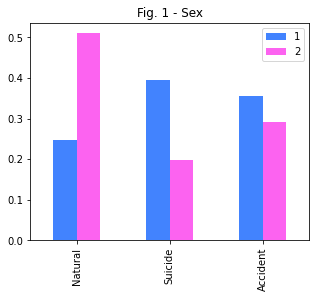

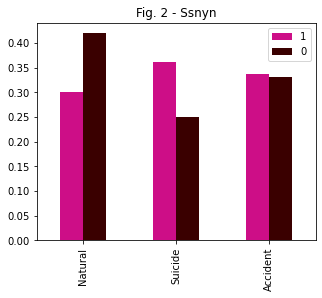

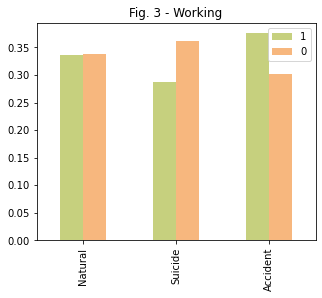

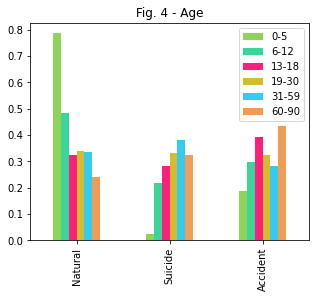

In [30]:
# plt.subplot( 4, 3, 1 )
random.seed(1)
for index, col in enumerate( cols_to_plot ):
    colors = [
    "#{0}".format( ''.join( [ random.choice( '0123456789ABCDEF' ) for j in range( 6 ) ] ) )
                  for i in range( data[ col ].unique().shape[0] )
        ]
    ax = pd.DataFrame(
        pd.concat([
                data.loc[ data[ output_column ] == 0, col ].value_counts(),
                data.loc[ data[ output_column ] == 1, col ].value_counts(),
                data.loc[ data[ output_column ] == 2, col ].value_counts()
            ], axis = 1
        ).values, columns = [ 'Natural', 'Suicide', 'Accident' ],
    index = data[ col ].unique().categories.tolist()
    ).copy( deep = True )
    # ax.legend( data[ col ].unique().categories.tolist() )
    ax = ax.div( ax.sum(axis = 1), axis = 0 ).T.plot( kind ='bar', figsize = (5, 4), color = colors )
    ax.set_title( "Fig. {0} - {1}".format( index + 1, col ) )

#### Findings
With the above plots, we could not find any striking difference in the reasons of death by attribute. But, there are cases where one of the categories in an attribute has most death count.
For example: 
1. Race = 2 ( Black ) has had most accidents in comparison to other 4 categories of Race
2. Race = 1 (White) has had most suicides, and
3. Race = 5 (Other non white) have had most deaths due to health issues

Although, we cannot yet comment if any of the attributes has driven towards intentional loss of life.
We'll try and explore the data further using Random forest, to also find out important factors using permutation importance of the variable.

#### Modelling
We'll try modelling the data in two ways:
1. use the data with their category codes (which are represented as numbers)
2. one-hot encode the data to have an individual column which describes its effect in binary

In [31]:
accuracy_scores_rf = {}
train_accuracy_scores_rf = {}

In [32]:
data['Age'].unique()

[31-59, 60-90, 19-30, 6-12, 13-18, 0-5]
Categories (6, object): [0-5 < 6-12 < 13-18 < 19-30 < 31-59 < 60-90]

In [33]:
# lets convert Age groups into number codes, so as to make the data eligible for use by Random Forest
data[ 'Age'] = data['Age'].cat.codes.values
data[ 'Pob' ] = data[ 'Pob' ].cat.codes.values
data[ 'Stater' ] = data[ 'Stater' ].cat.codes.values

In [34]:
data_copy = data.copy(deep = True)
data = data.loc[ data[ output_column ].isin( [ 1, 0 ] ) ].reset_index( drop = True )

In [35]:
# split data into train, and test
X_train, X_test, y_train, y_test = fetch_train_test_split( data, output_column, random_state = 42, stratify = True )

# create RF classifier
rf_model = get_rf_model( X_train, y_train, output_column, random_state = 42 )
# calculate accuracy
accuracy_scores_rf[ 'rf_raw' ] = accuracy_score( y_test, rf_model.predict( X_test ) )
train_accuracy_scores_rf[ 'rf_raw' ] = accuracy_score( y_train, rf_model.predict( X_train ) )
print( "Accuracy: {0}".format( accuracy_scores_rf[ 'rf_raw' ] ) )

Accuracy: 0.9419354838709677


In [36]:
perm = PermutationImportance( rf_model, random_state = 42 ).fit( X_test, y_test )
eli5.show_weights( perm, feature_names = X_test.columns.tolist() )

Weight,Feature
0.4315 ± 0.0342,Follow
0.0100 ± 0.0036,Sex
0.0044 ± 0.0036,Hhnum
0.0037 ± 0.0062,Stater
0.0006 ± 0.0015,Pob
0.0004 ± 0.0025,Age
0.0004 ± 0.0038,Majind
-0.0007 ± 0.0034,Ssnyn
-0.0020 ± 0.0014,Working
-0.0024 ± 0.0047,Majocc


Here, the data shows follow-up period to be the most important factor. But, since the attribute only represents the number of days an indivudal as followed by the survey team. It cannot drive a persons health. 
Lets get rid of this variable, and assess again.

In [37]:
data.drop( columns = [ 'Follow' ], inplace = True, errors = 'ignore' )

In [38]:
# split data into train, and test
X_train, X_test, y_train, y_test = fetch_train_test_split( data, output_column, random_state = 42, stratify = True )

# create RF classifier
rf_model = get_rf_model( X_train, y_train, output_column, random_state = 42 )
# calculate accuracy
accuracy_scores_rf[ 'rf_raw' ] = accuracy_score_rf = accuracy_score( y_test, rf_model.predict( X_test ) )
train_accuracy_scores_rf[ 'rf_raw' ] = accuracy_score_rf = accuracy_score( y_train, rf_model.predict( X_train ) )
print( "Accuracy with test data: {0}".format( accuracy_scores_rf[ 'rf_raw' ] ) )

perm = PermutationImportance( rf_model, random_state = 42 ).fit( X_test, y_test )
eli5.show_weights( perm, feature_names = X_test.columns.tolist() )

Accuracy with test data: 0.6488479262672812


Weight,Feature
0.0855 ± 0.0204,Sex
0.0400 ± 0.0162,Hhnum
0.0197 ± 0.0097,Age
0.0182 ± 0.0283,Stater
0.0127 ± 0.0183,Ssnyn
0.0028 ± 0.0093,Pob
0.0017 ± 0.0105,Majind
0.0006 ± 0.0150,Majocc
-0.0004 ± 0.0057,Working


In [39]:
md( "Now, the accuracy of the model has reduced to {0}%, and the most important variables now seem to be Gender, and Race.".format( round( accuracy_scores_rf[ 'rf_raw' ], 4 ) * 100 ) )

Now, the accuracy of the model has reduced to 64.88000000000001%, and the most important variables now seem to be Gender, and Race.

In [40]:
from sklearn.feature_selection import RFE
rfe = RFE( rf_model, n_features_to_select = round( 0.8 * len(X_train.columns) ), step = 1 )
rfe.fit( X_train, y_train )

important_features = X_train.columns[ rfe.get_support(True) ]
unimportant_features = np.setdiff1d( X_train.columns, important_features )

In [41]:
unimportant_features

array(['Ssnyn', 'Working'], dtype=object)

In [42]:
md( 
    """Variables found to be of least importance: '{0}'.
    
| Variable |                       Definition                      |
|:--------:|:-----------------------------------------------------:|
| Histatus |                Health Insurance Status                |
|    Race    |                     Race                    |
|  Working |                   Employment status                   |
| Hisp     | Hispanic origin( Mexican, Non Mexican, Non-Hispanic ) |

Same can be validated with the importance from Permutation importance below:""".format(
    "', '".join( unimportant_features ) )
)


Variables found to be of least importance: 'Ssnyn', 'Working'.
    
| Variable |                       Definition                      |
|:--------:|:-----------------------------------------------------:|
| Histatus |                Health Insurance Status                |
|    Race    |                     Race                    |
|  Working |                   Employment status                   |
| Hisp     | Hispanic origin( Mexican, Non Mexican, Non-Hispanic ) |

Same can be validated with the importance from Permutation importance below:

In [43]:
feature_imp = dict( zip( X_test.columns, perm.feature_importances_ ) )
sorted( feature_imp.items(), key = lambda x : x[1], reverse = True )

[('Sex', 0.08552995391705076),
 ('Hhnum', 0.040000000000000015),
 ('Age', 0.019723502304147524),
 ('Stater', 0.018248847926267332),
 ('Ssnyn', 0.012718894009216618),
 ('Pob', 0.0027649769585254003),
 ('Majind', 0.0016589861751152624),
 ('Majocc', 0.0005529953917051244),
 ('Working', -0.0003686635944699868)]

#### re-building the model using only the important featues now

In [44]:
X_train, X_test, y_train, y_test = fetch_train_test_split( data[ important_features.tolist() + [output_column] ], output_column, random_state = 42, stratify = True )
# re-create the model with new data shape
rf_model = get_rf_model( X_train, y_train, output_column )
# calculate accuracy
accuracy_scores_rf[ 'rf_raw_with_imp_cols' ] = accuracy_score( y_test, rf_model.predict( X_test ) )
train_accuracy_scores_rf[ 'rf_raw_with_imp_cols' ] = accuracy_score( y_train, rf_model.predict( X_train ) )
print( "Accuracy: {0}".format( accuracy_scores_rf[ 'rf_raw_with_imp_cols' ] ) )

Accuracy: 0.6387096774193548


In [45]:
perm = PermutationImportance( rf_model, random_state = 42 ).fit( X_test, y_test )
eli5.show_weights( perm, feature_names = X_test.columns.tolist() )

Weight,Feature
0.0888 ± 0.0194,Sex
0.0297 ± 0.0173,Hhnum
0.0254 ± 0.0146,Age
0.0114 ± 0.0188,Majind
0.0096 ± 0.0131,Majocc
0.0079 ± 0.0034,Pob
0.0061 ± 0.0172,Stater


In [46]:
md( 
    """This shows an impact of {0} on the accuracy without those {1} variables.""".format(
        round( accuracy_scores_rf[ 'rf_raw_with_imp_cols' ] - accuracy_scores_rf[ 'rf_raw' ], 5), 
        unimportant_features
    )
  )

This shows an impact of -0.01014 on the accuracy without those ['Ssnyn' 'Working'] variables.

#### Factorize
Now, we move ahead with one-hot encoding the categorical variables, and then build over it.

In [47]:
# encode cartegory columns into separate columns using one-hot encoding
factorization_technique = 'one-hot'
data_ = encode_str_columns( data.astype(str), technique = factorization_technique, str_attributes = None, max_unique_values_allowed_for_str = None, drop_extras = False, output_column = output_column )
"""scaler = StandardScaler()
data_[ number_cols ] = scaler.fit_transform( data_[ number_cols ] )"""

for x in data_.columns:
    # data_[ x ] = pd.to_numeric( data_[x] )
    data_[ x ] = data_[x].astype( int )

# split into train-test
X_train, X_test, y_train, y_test = fetch_train_test_split( data_, output_column, random_state = 42, stratify = True )

# re-create the model with new data shape
rf_model = get_rf_model( X_train, y_train, output_column )

# calculate accuracy
accuracy_scores_rf[ 'rf_raw_one_hot_encoded' ] = accuracy_score( y_test, rf_model.predict( X_test ) )
train_accuracy_scores_rf[ 'rf_raw_one_hot_encoded' ] = accuracy_score( y_train, rf_model.predict( X_train ) )
print( "\n\nAccuracy: '{0}', change: '{1}'".format( 
    accuracy_scores_rf[ 'rf_raw_one_hot_encoded' ], 
    round( accuracy_scores_rf[ 'rf_raw_one_hot_encoded' ] - accuracy_scores_rf[ 'rf_raw' ], 4 ) ) )

string columns found: ['Sex', 'Hhnum', 'Majocc', 'Majind', 'Ssnyn', 'Working', 'Age', 'Pob', 'Stater']
encoding Sex, Ssnyn, Working, Age, Stater, Majocc, Pob, Hhnum, Majind using one-hot
time taken to create dummy variables: 0.0100 secs


Accuracy: '0.6433179723502304', change: '-0.0055'


In [48]:
# lets try finding best params for Random Forest using Cross validation, and finally re-train the model

from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

optimal_params = GridSearchCV( 
        estimator = RandomForestClassifier( random_state = 42 ), 
        param_grid = random_grid,
        scoring = 'roc_auc',
        cv = 3, n_jobs = 10, verbose = 2
    )
optimal_params.fit( X_train, y_train )

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   37.3s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed:  9.6min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 12.7min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 16.3min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 20.3min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed: 24.7min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed: 29.6min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed: 34.5min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed: 40.4min
[Parallel(n_jobs=10)]: Done 9093 tasks      | 

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
             iid='deprecated', n_jobs=10,
             param_grid={'bootstrap': [True, False],
                

In [49]:
optimal_params.best_params_, optimal_params.best_score_

({'bootstrap': True,
  'max_depth': 10,
  'max_features': 'auto',
  'min_samples_leaf': 4,
  'min_samples_split': 2,
  'n_estimators': 800},
 0.7318880795776731)

In [50]:
train_accuracy_scores_rf[ 'rf_cv' ] = accuracy_score( y_train, optimal_params.best_estimator_.predict( X_train ) )
accuracy_scores_rf[ 'rf_cv' ] = accuracy_score( y_test, optimal_params.best_estimator_.predict( X_test ) )

In [51]:
accuracy_scores_rf

{'rf_raw': 0.6488479262672812,
 'rf_raw_with_imp_cols': 0.6387096774193548,
 'rf_raw_one_hot_encoded': 0.6433179723502304,
 'rf_cv': 0.6626728110599078}

In [52]:
perm = PermutationImportance( optimal_params.best_estimator_, random_state = 42 ).fit( X_test, y_test )
eli5.show_weights( perm, feature_names = X_test.columns.tolist() )

Weight,Feature
0.0312 ± 0.0286,Sex_2
0.0177 ± 0.0234,Sex_1
0.0061 ± 0.0063,Age_0
0.0026 ± 0.0029,Stater_3
0.0018 ± 0.0020,Majind_5
0.0011 ± 0.0007,Majind_9
0.0009 ± 0.0000,Hhnum_8
0.0009 ± 0.0012,Stater_8
0.0009 ± 0.0012,Hhnum_4
0.0009 ± 0.0016,Stater_2


In [53]:
from sklearn.feature_selection import RFE
rfe = RFE( optimal_params.best_estimator_, n_features_to_select = round( 0.8 * len(X_train.columns) ), step = 1 )
rfe.fit( X_train, y_train )

important_features = X_train.columns[ rfe.get_support(True) ]
unimportant_features = np.setdiff1d( X_train.columns, important_features )

feature_imp = dict( zip( X_test.columns, perm.feature_importances_ ) )
sorted( feature_imp.items(), key = lambda x : x[1], reverse = True )

[('Sex_2', 0.031152073732718888),
 ('Sex_1', 0.01769585253456223),
 ('Age_0', 0.006082949308755747),
 ('Stater_3', 0.002580645161290307),
 ('Majind_5', 0.0018433179723502447),
 ('Majind_9', 0.0011059907834101601),
 ('Hhnum_4', 0.0009216589861751334),
 ('Hhnum_8', 0.0009216589861751334),
 ('Stater_2', 0.0009216589861751334),
 ('Stater_8', 0.0009216589861751334),
 ('Majocc_1', 0.0009216589861751112),
 ('Majocc_10', 0.0007373271889401067),
 ('Majind_3', 0.0005529953917050801),
 ('Age_1', 0.00036866359447005335),
 ('Pob_7', 0.00036866359447005335),
 ('Hhnum_9', 0.00018433179723502667),
 ('Majind_13', 0.00018433179723502667),
 ('Stater_5', 0.00018433179723502667),
 ('Stater_7', 0.00018433179723502667),
 ('Hhnum_10', 0.0),
 ('Hhnum_11', 0.0),
 ('Hhnum_12', 0.0),
 ('Hhnum_13', 0.0),
 ('Hhnum_14', 0.0),
 ('Hhnum_16', 0.0),
 ('Majocc_11', 0.0),
 ('Majocc_2', 0.0),
 ('Majocc_4', 0.0),
 ('Majocc_6', 0.0),
 ('Majocc_8', 0.0),
 ('Majind_1', 0.0),
 ('Majind_12', 0.0),
 ('Majind_14', 0.0),
 ('Majind_

In [54]:
# backup the extracted data to use in further analysis
write_excel_sheet_v2( data, "output/data/data_filtered_imputed_clean_v2.csv")
write_excel_sheet_v2( data_, "output/data/data_filtered_imputed_encoded.csv")

finally writing .csv file: 'data_filtered_imputed_clean_v2.csv'
finally writing .csv file: 'data_filtered_imputed_encoded.csv'


WindowsPath('output/data/data_filtered_imputed_encoded.csv')

In [58]:
accuracy_scores_df = pd.DataFrame.from_dict( accuracy_scores_rf.items() )
accuracy_scores_df.columns = ['approach', 'test_accuracy']

Text(0.5, 1.0, 'RandomForestClassifier')

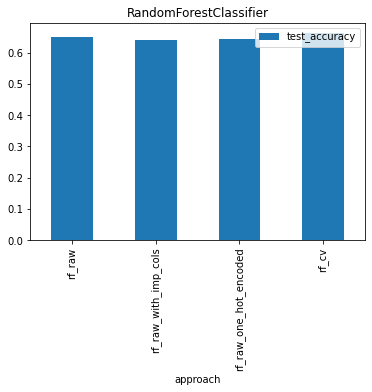

In [59]:
plt_ = accuracy_scores_df.set_index( 'approach' ).plot( kind ='bar' )
plt_.set_title( "RandomForestClassifier" )

In [ ]:
train_accuracy_scores_df = pd.DataFrame.from_dict( train_accuracy_scores_rf.items() )
train_accuracy_scores_df.columns = ['approach', 'train_accuracy']

In [62]:
write_excel_sheet_v2( pd.merge( accuracy_scores_df, train_accuracy_scores_df, on = 'approach' ), "output/accuracy/rf.xlsx" )

finally writing .xlsx file: 'rf.xlsx'


WindowsPath('output/accuracy/rf.xlsx')